In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Load dataset
df = pd.read_csv('SQLiV3.csv')

# Clean the dataset by dropping any rows with NaN in the 'Sentence' or 'Label' columns
df = df.dropna(subset=['Sentence', 'Label'])

# Remove rows where 'Label' is not numeric or is NaN
df = df[df['Label'].apply(lambda x: str(x).isdigit())]

# Convert 'Label' to integers
df['Label'] = df['Label'].astype(int)

In [3]:
# Select features and target
X = df['Sentence']  # Input feature: SQL query strings
y = df['Label']     # Target: 1 for SQL injection, 0 for normal queries

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

In [4]:
# Set up Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)

# Pipeline for Isolation Forest
pipeline_iso = Pipeline([
    ('vectorizer', vectorizer),
    ('isolation_forest', iso_forest)
])

# Fit the pipeline on the training data
pipeline_iso.fit(X_train)

# Predict anomalies in the test set using Isolation Forest
y_pred_iso = pipeline_iso.predict(X_test)

# Convert Isolation Forest output to match binary labels
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

In [5]:
# Evaluate Isolation Forest with TF-IDF
print("Isolation Forest (with TF-IDF) Classification Report:")
print(classification_report(y_test, y_pred_iso))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_iso))

Isolation Forest (with TF-IDF) Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.96      0.80      3828
           1       0.81      0.25      0.38      2294

    accuracy                           0.70      6122
   macro avg       0.74      0.61      0.59      6122
weighted avg       0.73      0.70      0.64      6122

Confusion Matrix:
[[3694  134]
 [1729  565]]


In [6]:
# Set up Random Forest for the hybrid model
rf_classifier = RandomForestClassifier(random_state=42)

# Pipeline for Random Forest
pipeline_rf = Pipeline([
    ('vectorizer', vectorizer),
    ('random_forest', rf_classifier)
])

# Fit the pipeline on the training data
pipeline_rf.fit(X_train, y_train)

# Predict using Random Forest
y_pred_rf = pipeline_rf.predict(X_test)

# Hybrid Model - Majority voting between Isolation Forest and Random Forest
y_pred_hybrid = (y_pred_iso + y_pred_rf) // 2


In [7]:
# Evaluate Hybrid Model
print("\nHybrid Model (Isolation Forest + Random Forest) Classification Report:")
print(classification_report(y_test, y_pred_hybrid))
print("Confusion Matrix:")
hybrid_conf_matrix = confusion_matrix(y_test, y_pred_hybrid)
print(hybrid_conf_matrix)



Hybrid Model (Isolation Forest + Random Forest) Classification Report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      3828
           1       1.00      0.25      0.40      2294

    accuracy                           0.72      6122
   macro avg       0.84      0.62      0.61      6122
weighted avg       0.81      0.72      0.66      6122

Confusion Matrix:
[[3828    0]
 [1729  565]]


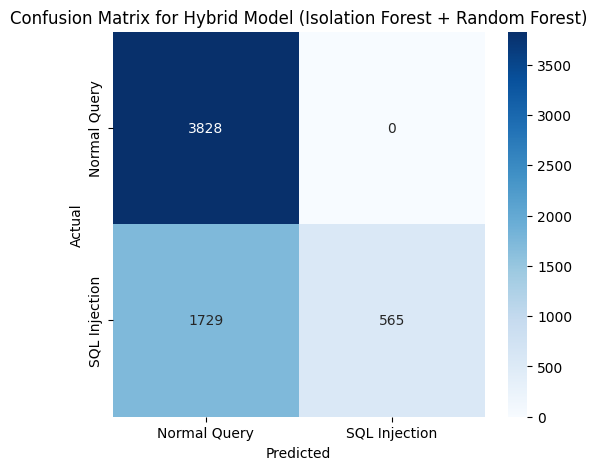

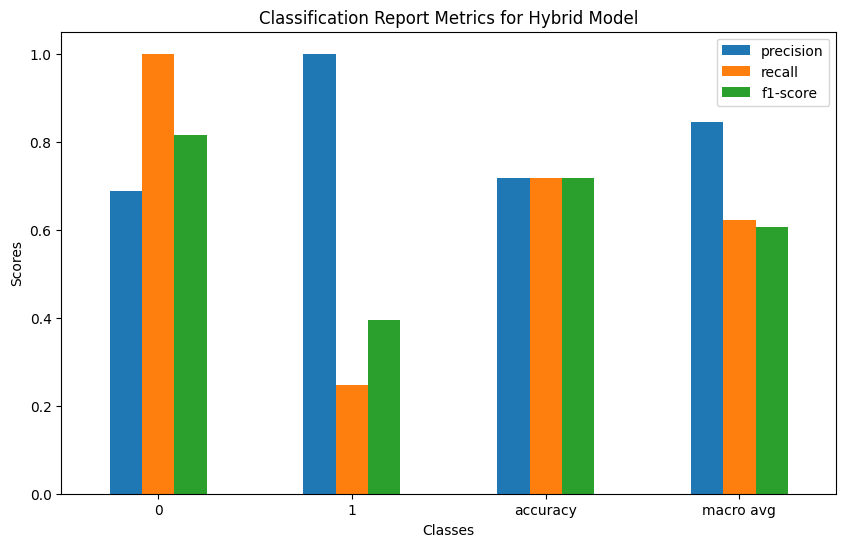

In [8]:
# Plot Confusion Matrix as Heatmap for the Hybrid Model
plt.figure(figsize=(6, 5))
sns.heatmap(hybrid_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Query', 'SQL Injection'], yticklabels=['Normal Query', 'SQL Injection'])
plt.title('Confusion Matrix for Hybrid Model (Isolation Forest + Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Extract Classification Report for Visualization
report = classification_report(y_test, y_pred_hybrid, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plot Precision, Recall, and F1-Score
df_report[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10, 6))
plt.title('Classification Report Metrics for Hybrid Model')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.xticks(rotation=0)
plt.show()